## GQA Question Engine

In [3]:
import json
import networkx as nx
import matplotlib.pyplot as plt

def load_scene_graph(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

scene_graph_file = 'data/sceneGraphs/train_sceneGraphs.json'
scene_graph_data = load_scene_graph(scene_graph_file)

{
    "1665235": {
        "attributes": [],
        "h": 194,
        "name": "ground",
        "relations": [
            {
                "name": "to the right of",
                "object": "2223553"
            },
            {
                "name": "to the right of",
                "object": "1855767"
            },
            {
                "name": "to the right of",
                "object": "2608901"
            },
            {
                "name": "to the right of",
                "object": "2444445"
            }
        ],
        "w": 257,
        "x": 144,
        "y": 179
    },
    "1734279": {
        "attributes": [],
        "h": 48,
        "name": "menu",
        "relations": [
            {
                "name": "to the left of",
                "object": "1941208"
            },
            {
                "name": "to the right of",
                "object": "2223553"
            },
            {
                "name": "to the right of",
       

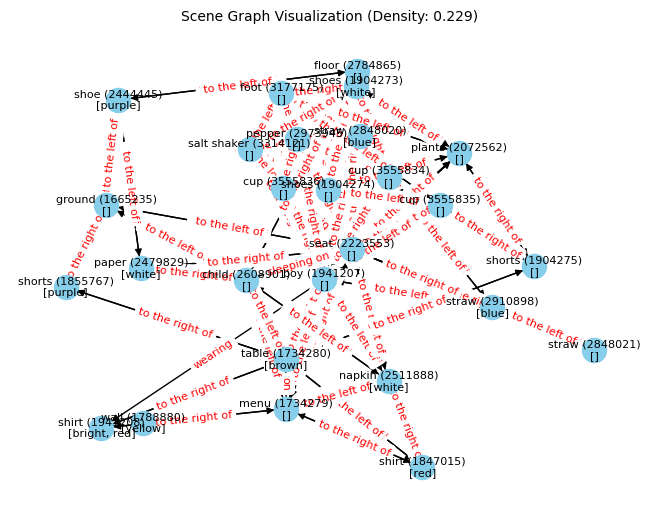

In [8]:
# Example image ID
# 2338159
# 2382734
# 2357213

image_id = "2357213"

if image_id in scene_graph_data:
    image_data = scene_graph_data[image_id]["objects"]
else:
    raise ValueError(f"Image ID {image_id} not found in the scene graph data")

print(json.dumps(image_data, sort_keys=True, indent=4))

# Create a graph
G = nx.DiGraph()

for obj_id, obj_data in image_data.items():
    obj_name = f'{obj_data["name"]} ({obj_id})'
    attributes = ', '.join(obj_data["attributes"]) if "attributes" in obj_data else ""
    label = f'{obj_name}\n[{attributes}]'
    
    # Add object node with attributes
    G.add_node(obj_id, label=label)
    
    # Add edges for relationships
    if "relations" in obj_data:
        for relation in obj_data["relations"]:
            target_obj = relation["object"]
            relation_name = relation["name"]
            G.add_edge(obj_id, target_obj, label=relation_name)

# Get graph density and node count to adjust layout and size
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
graph_density = nx.density(G)  # Density: edges / possible edges

# Dynamic scaling based on the number of nodes and edges
scale_factor = max(1, num_nodes / 30)  # Adjust based on node count
node_size = max(200, 300 / scale_factor)  # Dynamic node size
font_size = max(5, 8 / scale_factor)     # Dynamic font size
k_value = max(0.5, 1 / scale_factor)    # Dynamic spacing between nodes

# Define position layout (spring_layout) with dynamic k based on density
pos = nx.spring_layout(G, k=k_value)

# Draw nodes with dynamic size and labels with dynamic font size
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
        node_size=node_size, node_color='skyblue', font_size=font_size, font_weight='light')

# Draw edges with smaller labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=font_size)

# Display the plot with adjusted title size
plt.title(f"Scene Graph Visualization (Density: {graph_density:.3f})", fontsize=10)
plt.show()


In [14]:
import random

# Generate questions from objects and their attributes
def generate_object_attribute_questions(objects):
    questions = []
    for obj_id, obj_data in objects.items():
        obj_name = obj_data['name']
        attributes = obj_data.get('attributes', [])
        
        # For each attribute, generate a question
        for attribute in attributes:
            question = f"What {attribute} is the {obj_name}?"
            questions.append(question)
            question = f"Is the {obj_name} {attribute}?"
            questions.append(question)
    
    return questions

# Generate questions from object relations
def generate_relation_questions(objects):
    questions = []
    for obj_id, obj_data in objects.items():
        obj_name = obj_data['name']
        
        # For each relation, generate a question
        for relation in obj_data.get('relations', []):
            relation_name = relation['name']
            target_obj_id = relation['object']
            target_obj_name = objects[target_obj_id]['name']
            
            question = f"Which object is {relation_name} the {obj_name}?"
            questions.append(question)
            question = f"Does the {target_obj_name} is {relation_name} the {obj_name}?"
            questions.append(question)
    
    return questions

def generate_questions(image_id, scene_graph_data):
    if image_id not in scene_graph_data:
        raise ValueError(f"Image ID {image_id} not found in the scene graph data")

    image_data = scene_graph_data[image_id]["objects"]
    
    attribute_questions = generate_object_attribute_questions(image_data)
    relation_questions = generate_relation_questions(image_data)
    
    all_questions = attribute_questions + relation_questions
    return all_questions


questions = generate_questions(image_id, scene_graph_data)

for q in questions:
    print(q)


What purple is the shorts?
Is the shorts purple?
What blue is the straw?
Is the straw blue?
What red is the shirt?
Is the shirt red?
What purple is the shoe?
Is the shoe purple?
What white is the napkin?
Is the napkin white?
What blue is the straw?
Is the straw blue?
What bright is the shirt?
Is the shirt bright?
What red is the shirt?
Is the shirt red?
What white is the shoes?
Is the shoes white?
What yellow is the wall?
Is the wall yellow?
What brown is the table?
Is the table brown?
What white is the paper?
Is the paper white?
Which object is to the left of the shorts?
Does the table is to the left of the shorts?
Which object is to the left of the shorts?
Does the ground is to the left of the shorts?
Which object is to the left of the straw?
Does the foot is to the left of the straw?
Which object is to the left of the straw?
Does the shoes is to the left of the straw?
Which object is to the right of the straw?
Does the seat is to the right of the straw?
Which object is to the right 